In [1]:
# dataset from https://www.kaggle.com/datasets/javi2270784/gas-sensor-array-temperature-modulation/data
# references from  [1] and [2]
# [1] Burgués, Javier, Juan Manuel Jiménez-Soto, and Santiago Marco. "Estimation of the limit of detection in semiconductor gas sensors through linearized calibration models." Analytica chimica acta 1013 (2018): 13-25.
# [2] Burgués, Javier, and Santiago Marco. "Multivariate estimation of the limit of detection by orthogonal partial least squares in temperature-modulated MOX sensors." Analytica chimica acta 1019 (2018): 49-64.

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from pandas import json_normalize
from pysr import PySRRegressor # 初回のimportでは時間がかかる
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import KFold, StratifiedKFold
from tqdm.notebook import tqdm

Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


In [3]:
# ../input/gas-sensor-array-temperature-modulation/20160930_203718.csvを読み込む
df_20160930_203718 = pd.read_csv('../input/gas-sensor-array-temperature-modulation/20160930_203718.csv')
print(df_20160930_203718.shape)
# ../input/gas-sensor-array-temperature-modulation/20161001_231809.csvを読み込む
df_20161001_231809 = pd.read_csv('../input/gas-sensor-array-temperature-modulation/20161001_231809.csv')
print(df_20161001_231809.shape)
# ../input/gas-sensor-array-temperature-modulation/20161003_085624.csvを読み込む
df_20161003_085624 = pd.read_csv('../input/gas-sensor-array-temperature-modulation/20161003_085624.csv')
print(df_20161003_085624.shape)
# ../input/gas-sensor-array-temperature-modulation/20161004_104124.csvを読み込む
df_20161004_104124 = pd.read_csv('../input/gas-sensor-array-temperature-modulation/20161004_104124.csv')
print(df_20161004_104124.shape)
# ../input/gas-sensor-array-temperature-modulation/20161005_140846.csvを読み込む
df_20161005_140846 = pd.read_csv('../input/gas-sensor-array-temperature-modulation/20161005_140846.csv')
print(df_20161005_140846.shape)
# ../input/gas-sensor-array-temperature-modulation/20161006_182224.csvを読み込む
df_20161006_182224 = pd.read_csv('../input/gas-sensor-array-temperature-modulation/20161006_182224.csv')
print(df_20161006_182224.shape)
# ../input/gas-sensor-array-temperature-modulation/20161007_210049.csvを読み込む
df_20161007_210049 = pd.read_csv('../input/gas-sensor-array-temperature-modulation/20161007_210049.csv')
print(df_20161007_210049.shape)
# ../input/gas-sensor-array-temperature-modulation/20161008_234508.csvを読み込む
df_20161008_234508 = pd.read_csv('../input/gas-sensor-array-temperature-modulation/20161008_234508.csv')
print(df_20161008_234508.shape)
# ../input/gas-sensor-array-temperature-modulation/20161010_095046.csvを読み込む
df_20161010_095046 = pd.read_csv('../input/gas-sensor-array-temperature-modulation/20161010_095046.csv')
print(df_20161010_095046.shape)
# ../input/gas-sensor-array-temperature-modulation/20161011_113032.csvを読み込む
df_20161011_113032 = pd.read_csv('../input/gas-sensor-array-temperature-modulation/20161011_113032.csv')
print(df_20161011_113032.shape)
# ../input/gas-sensor-array-temperature-modulation/20161013_143355.csvを読み込む
df_20161013_143355 = pd.read_csv('../input/gas-sensor-array-temperature-modulation/20161013_143355.csv')
print(df_20161013_143355.shape)
# ../input/gas-sensor-array-temperature-modulation/20161014_184659.csvを読み込む
df_20161014_184659 = pd.read_csv('../input/gas-sensor-array-temperature-modulation/20161014_184659.csv')
print(df_20161014_184659.shape)
# ../input/gas-sensor-array-temperature-modulation/20161016_053656.csvを読み込む
df_20161016_053656 = pd.read_csv('../input/gas-sensor-array-temperature-modulation/20161016_053656.csv')
print(df_20161016_053656.shape)

(295719, 20)
(295516, 20)
(295700, 20)
(295653, 20)
(295534, 20)
(295499, 20)
(295700, 20)
(295524, 20)
(295747, 20)
(295391, 20)
(295679, 20)
(295881, 20)
(295617, 20)


In [4]:
# trainデータとして、df_20160930_203718~df_df_20161014_184659を結合
train = pd.concat([df_20160930_203718, df_20161001_231809, df_20161003_085624, df_20161004_104124, df_20161005_140846, df_20161006_182224, df_20161007_210049, df_20161008_234508, df_20161010_095046, df_20161011_113032, df_20161013_143355, df_20161014_184659])

In [5]:
# validationデータとして20161016_053656を使用
valid = df_20161016_053656

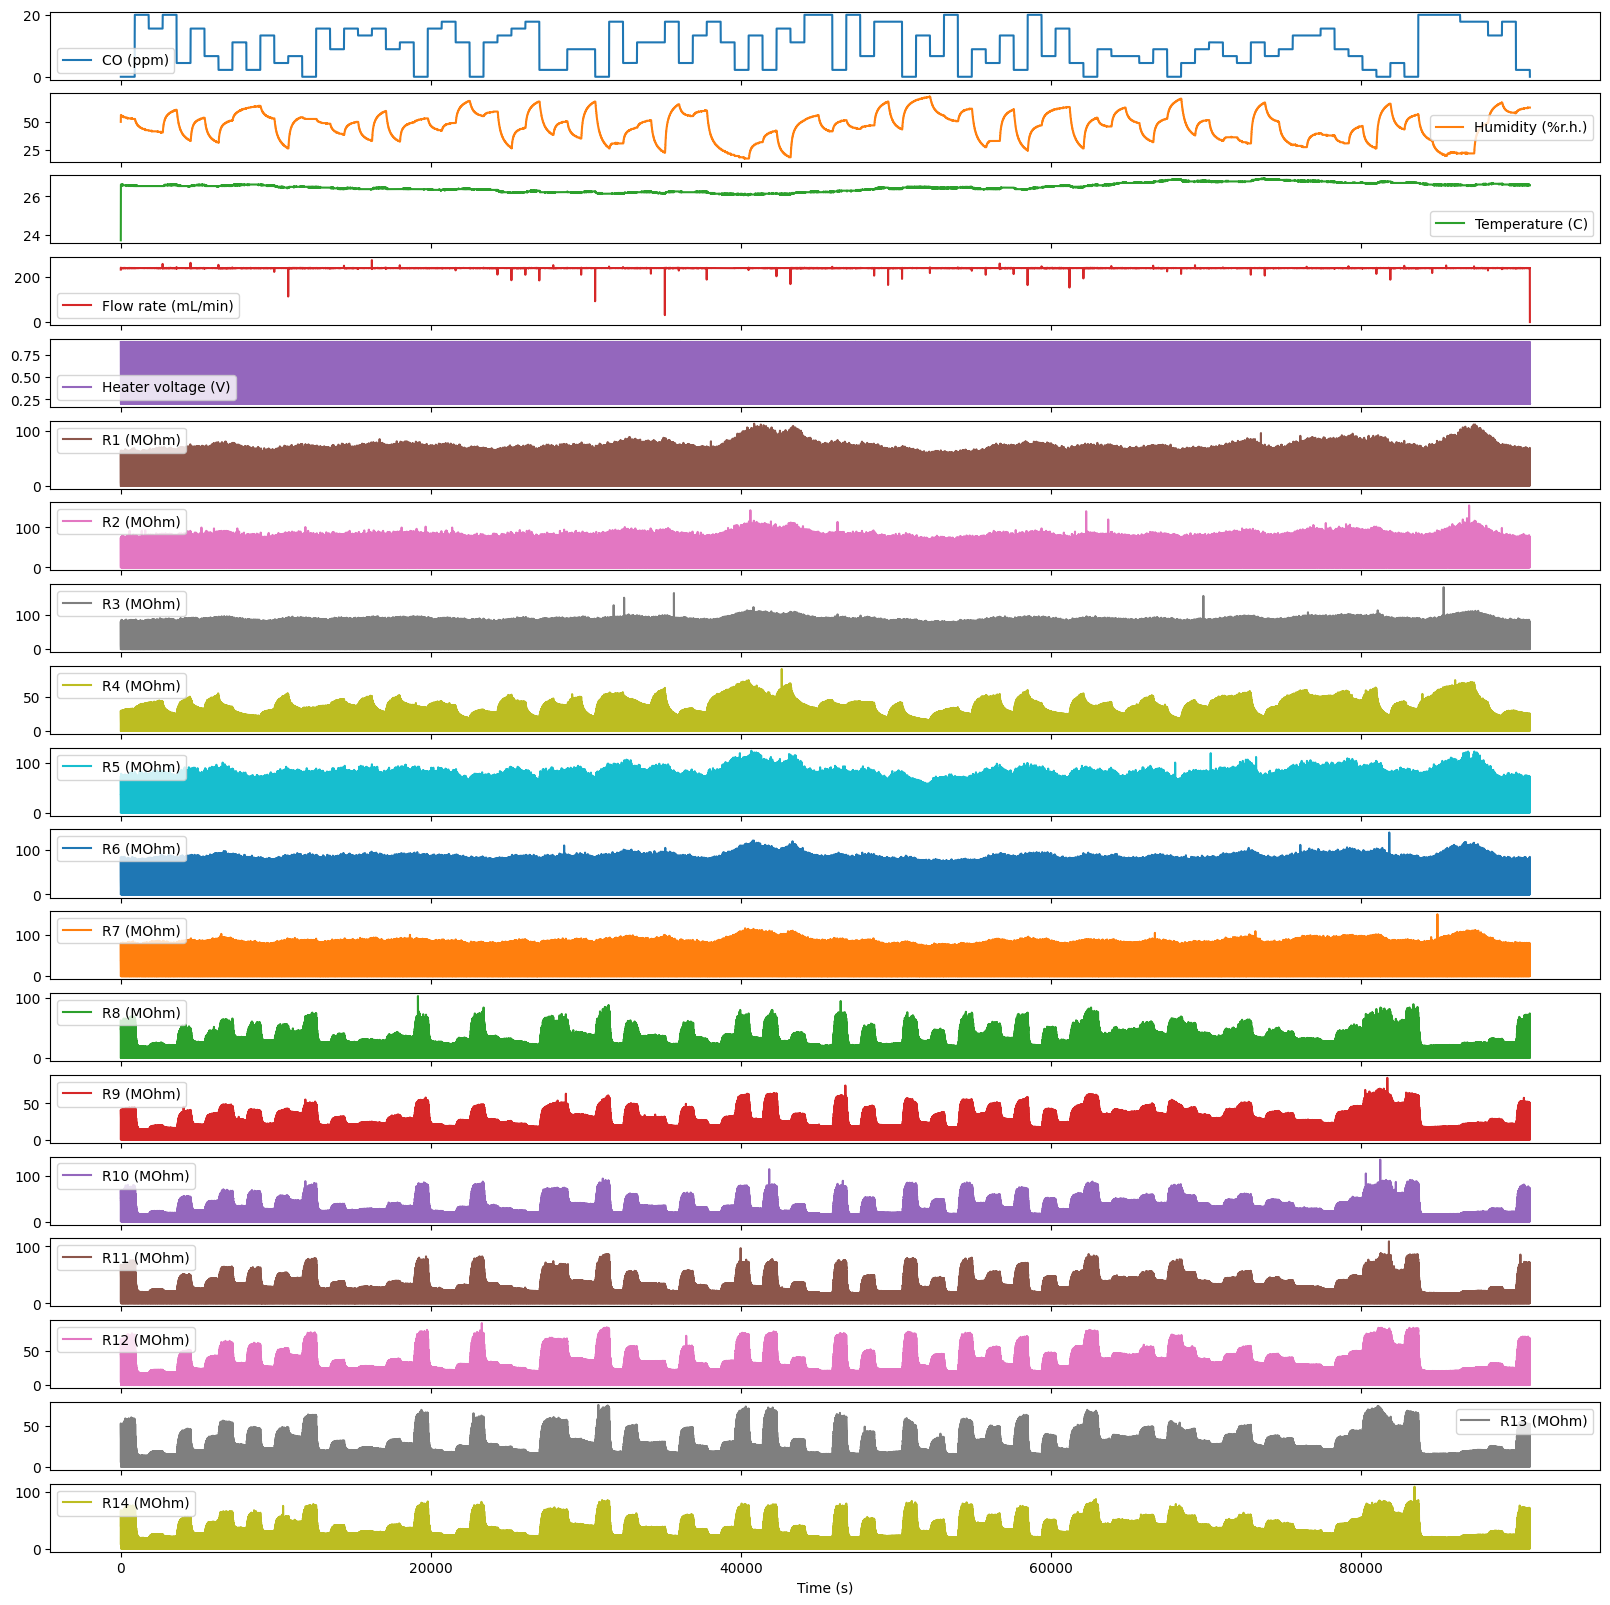

In [6]:
# df_20160930_203718のTime (s)を横軸に、縦軸にそれ以外の列を取り、グラフを描画
df_20160930_203718.plot(x='Time (s)', subplots=True, figsize=(20, 20))
plt.show()

In [7]:
train.columns

Index(['Time (s)', 'CO (ppm)', 'Humidity (%r.h.)', 'Temperature (C)',
       'Flow rate (mL/min)', 'Heater voltage (V)', 'R1 (MOhm)', 'R2 (MOhm)',
       'R3 (MOhm)', 'R4 (MOhm)', 'R5 (MOhm)', 'R6 (MOhm)', 'R7 (MOhm)',
       'R8 (MOhm)', 'R9 (MOhm)', 'R10 (MOhm)', 'R11 (MOhm)', 'R12 (MOhm)',
       'R13 (MOhm)', 'R14 (MOhm)'],
      dtype='object')

In [8]:
train.columns = ['Time', 'CO', 'Humidity', 'Temperature',
       'Flow rate', 'Heater voltage', 'R1', 'R2',
       'R3', 'R4', 'R5', 'R6', 'R7',
       'R8', 'R9', 'R10', 'R11', 'R12',
       'R13', 'R14'
]

valid.columns = ['Time', 'CO', 'Humidity', 'Temperature',
       'Flow rate', 'Heater voltage', 'R1', 'R2',
       'R3', 'R4', 'R5', 'R6', 'R7',
       'R8', 'R9', 'R10', 'R11', 'R12',
       'R13', 'R14'
]

In [21]:
# X_train, y_train, X_valid, y_validを作成
X_train = train.drop(columns=['Time', 'CO'])
y_train = train['CO']
X_valid = valid.drop(columns=['Time', 'CO'])
y_valid = valid['CO']

In [10]:
# シンボリック回帰のモデルを作成
model = PySRRegressor(niterations=40, batch_size=1000)

model.fit(X_train, y_train)

/opt/conda/lib/python3.10/site-packages/pysr/sr.py:2588: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/pysr/sr.py:1434: UserWarning: Spaces in DataFrame column names are not supported. Spaces have been replaced with underscores. 
Please rename the columns to valid names.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/pysr/sr.py:2029: UserWarning: Note: you are running with more than 10,000 datapoints. You should consider turning on batching (https://astroautomata.com/PySR/options/#batching). You should also reconsider if you need that many datapoints. Unless you have a large amount of noise (in which case you should smooth your dataset first), generally < 10,000 datapoints is enough to find a functional form with symbolic regression. More datapoints will lower the search speed.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/pysr/sr.py:2059: UserWarning: Note:

Compiling Julia backend...


[ Info: Note: you are running with more than 10,000 datapoints. You should consider turning on batching (`options.batching`), and also if you need that many datapoints. Unless you have a large amount of noise (in which case you should smooth your dataset first), generally < 10,000 datapoints is enough to find a functional form.
[ Info: Started!



Expressions evaluated per second: 0.000e+00
Head worker occupation: 0.0%
Progress: 0 / 600 total iterations (0.000%)
Hall of Fame:
---------------------------------------------------------------------------------------------------
Complexity  Loss       Score     Equation
---------------------------------------------------------------------------------------------------
Press 'q' and then <enter> to stop execution early.

Expressions evaluated per second: 0.000e+00
Head worker occupation: 0.0%
Progress: 0 / 600 total iterations (0.000%)
Hall of Fame:
---------------------------------------------------------------------------------------------------
Complexity  Loss       Score     Equation
---------------------------------------------------------------------------------------------------
Press 'q' and then <enter> to stop execution early.

Expressions evaluated per second: 0.000e+00
Head worker occupation: 0.0%
Progress: 0 / 600 total iterations (0.000%)
Hall of Fame:
----------------

PySRRegressor.equations_ = [
	   pick     score                                           equation  \
	0        0.000000                                            9.90061   
	1        0.079680                     14.090732 - (0.16049051 * R10)   
	2        0.066407          ((-0.0030435512 * R13) * R14) + 13.193567   
	3  >>>>  0.117678  (16.689093 - (Heater_voltage * (R14 - -10.8334...   
	4        0.000079  (16.689093 - (Heater_voltage * ((R14 - -10.833...   
	5        0.016621  ((-1.0103776 / R1) + ((0.32026678 * (0.9284264...   
	6        0.003082  ((11.899843 - (0.6572228 * (Heater_voltage * R...   
	7        0.016076  (((16.689093 - (Heater_voltage * (R14 - -10.83...   
	
	        loss  complexity  
	0  41.313095           1  
	1  30.037920           5  
	2  26.302017           7  
	3  20.786192           9  
	4  20.782915          11  
	5  20.103394          13  
	6  19.979877          15  
	7  19.347712          17  
]

In [12]:
model.get_best()['equation']

'(16.689093 - (Heater_voltage * (R14 - -10.833441))) * 1.4239125'

In [24]:
# vallidの予測値を求める
valid_preds = (16.689093 - (X_valid['Heater voltage'] * (X_valid['R14'] - -10.833441))) * 1.4239125
# validの予測値と正解値でRMSEとMAEを求める
rmse = np.sqrt(mean_squared_error(y_valid, valid_preds))
mae = mean_absolute_error(y_valid, valid_preds)
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")

RMSE: 4.501363044354793
MAE: 3.2155791050078397


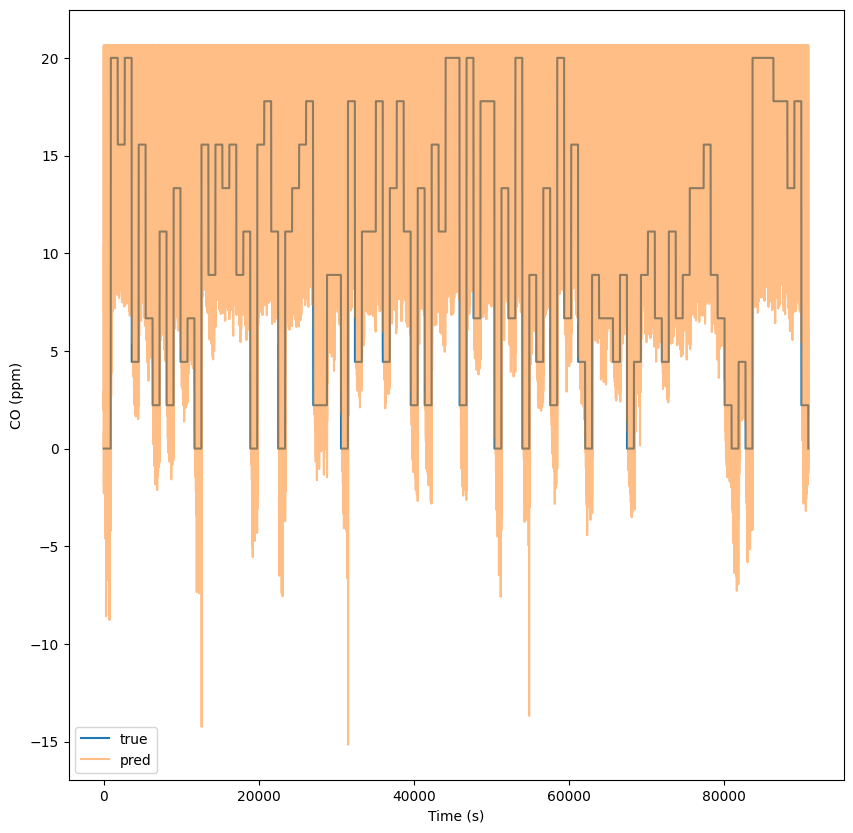

In [26]:
# y_valid, valid_predsを縦軸、横軸にTime (s)を取り、グラフを描画
plt.figure(figsize=(10, 10))
plt.plot(valid['Time'], y_valid, label='true')
plt.plot(valid['Time'], valid_preds, label='pred', alpha=0.5)
# 縦軸、横軸にラベルを付ける
plt.xlabel('Time (s)')
plt.ylabel('CO (ppm)')
plt.legend()

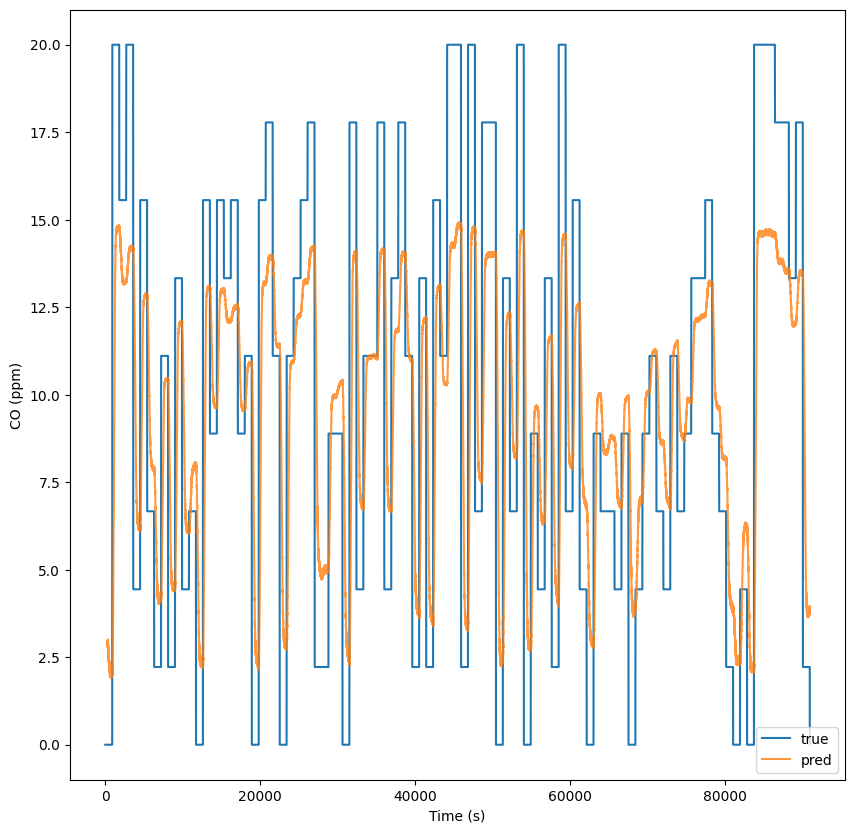

In [27]:
# predを移動平均で平滑化
pred = pd.Series(valid_preds)
pred_smooth = pred.rolling(window=1000).mean()
# y_valid, pred_smoothを縦軸、横軸にTime (s)を取り、グラフを描画
plt.figure(figsize=(10, 10))
plt.plot(valid['Time'], y_valid, label='true')
plt.plot(valid['Time'], pred_smooth, label='pred', alpha=0.8)
# 縦軸、横軸にラベルを付ける
plt.xlabel('Time (s)')
plt.ylabel('CO (ppm)')
plt.legend()